<h1 style = 'color: orange'> Decoding Sentiments in Movie Reviews: An NLP Approach  </h1>

This study focuses on creating a system to automatically detect negative movie reviews. The goal is to train a model that can classify reviews as either positive or negative, aiming for an F1 score of at least 0.85 to ensure high accuracy. 

To achieve this, we compare three different approaches: using NLTK with TF-IDF and Linear Regression, spaCy with TF-IDF and Linear Regression, and spaCy with TF-IDF and LGBMClassifier. Through this comparison, we aim to identify the most effective method for sentiment analysis in movie reviews, balancing both performance and efficiency.

<h2 style = 'color: orange'> Initialization  </h2>

In [1]:
import math
import logging

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import torch
import transformers

from tqdm.auto import tqdm

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
import spacy
from lightgbm import LGBMClassifier

from nltk.corpus import stopwords as nltk_stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Raphael\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Display a list of all available Matplotlib styles

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [2]:
# Configure Matplotlib to display and style plots in Jupyter Notebook

%matplotlib inline
%config InlineBackend.figure_format = 'png'
# The next line provides higher quality plots on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8-pastel')

In [3]:
# Enable progress bars for pandas operations https://pypi.org/project/tqdm/#pandas-integration

tqdm.pandas()

<h2 style = 'color: orange'> Reading Files:</h2>

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.shape

(47331, 17)

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

<h2 style = 'color: orange'> EDA:</h2>

Let's check the number of movies and reviews over the years.

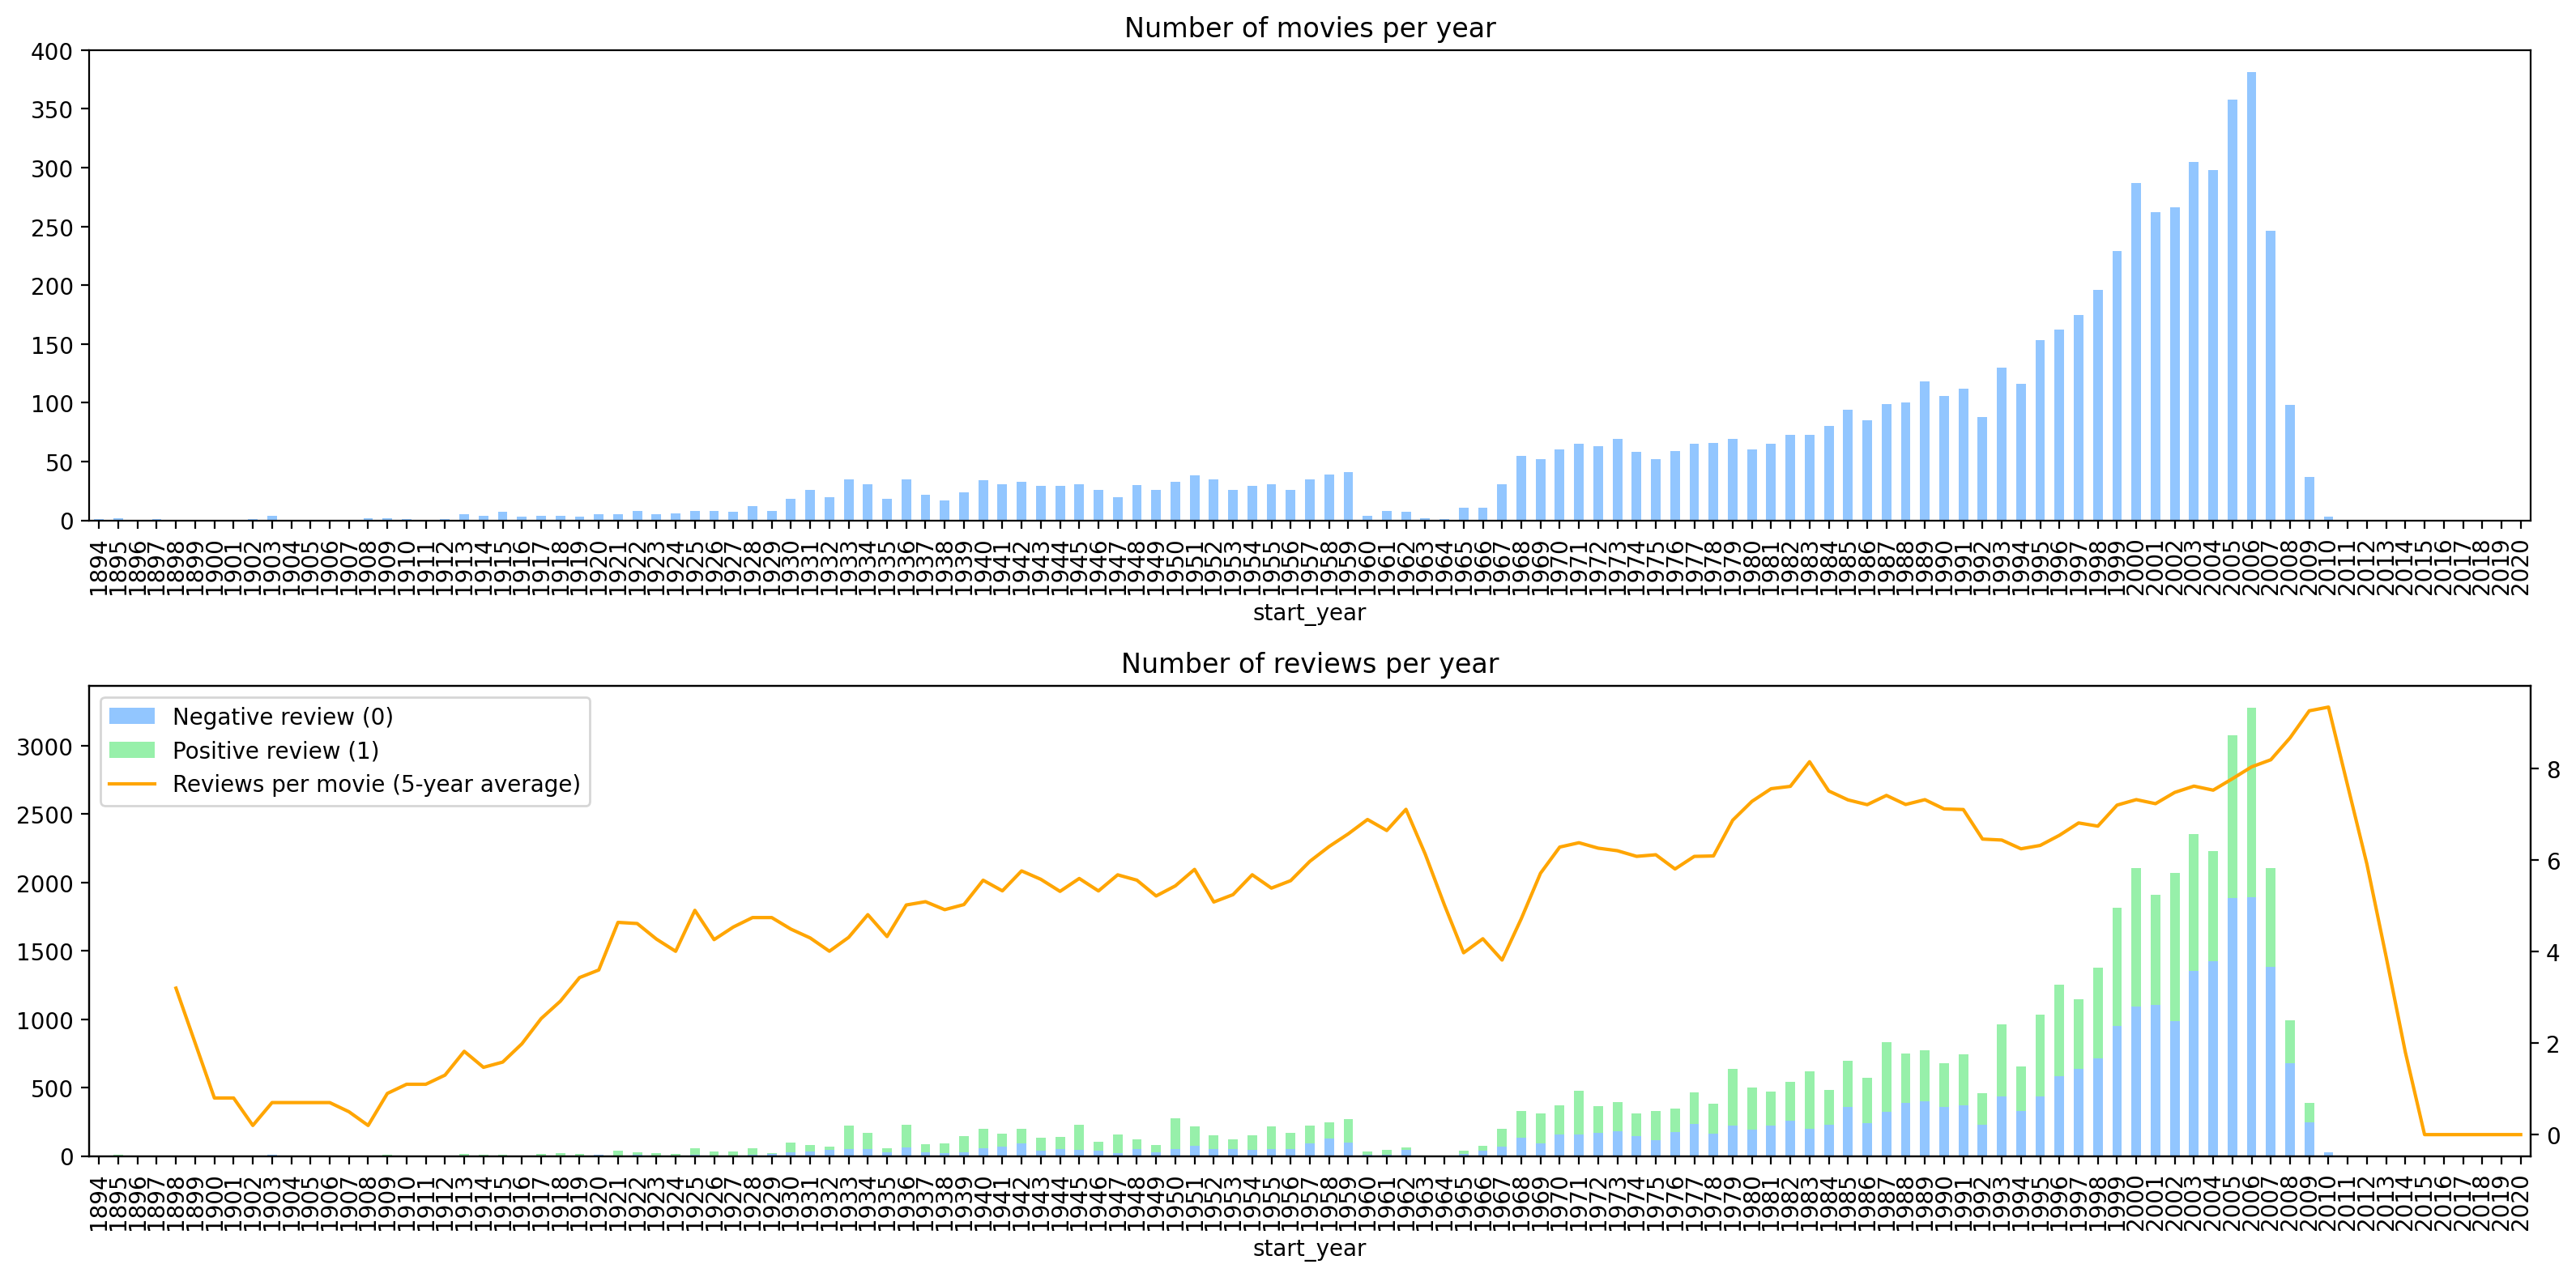

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

# First plot: Number of movies per year
ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of movies per year')

# Second plot: Number of reviews per year and average reviews per movie
ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Update column names to reflect positive and negative reviews
dft2.columns = ['Negative review (0)', 'Positive review (1)']

# Plot the stacked bars for positive and negative reviews
dft2.plot(kind='bar', stacked=True, ax=ax)

# Update dft2 to count the total number of reviews per year
dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

# Calculate the average number of reviews per movie
dft3 = (dft2 / dft1).fillna(0)

# Plot the moving average of reviews per movie
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reviews per movie (5-year average)', ax=axt)

# Get the legends from the bars and the line
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()

# Combine the legends and add them to the plot
ax.legend(lines + lines2, labels + labels2, loc='upper left')

ax.set_title('Number of reviews per year')

# Adjust layout
fig.tight_layout()

Let's check the distribution of the number of reviews per movie with the exact count and the KDE (Kernel Density Estimation—just to see how it may differ from the exact count).

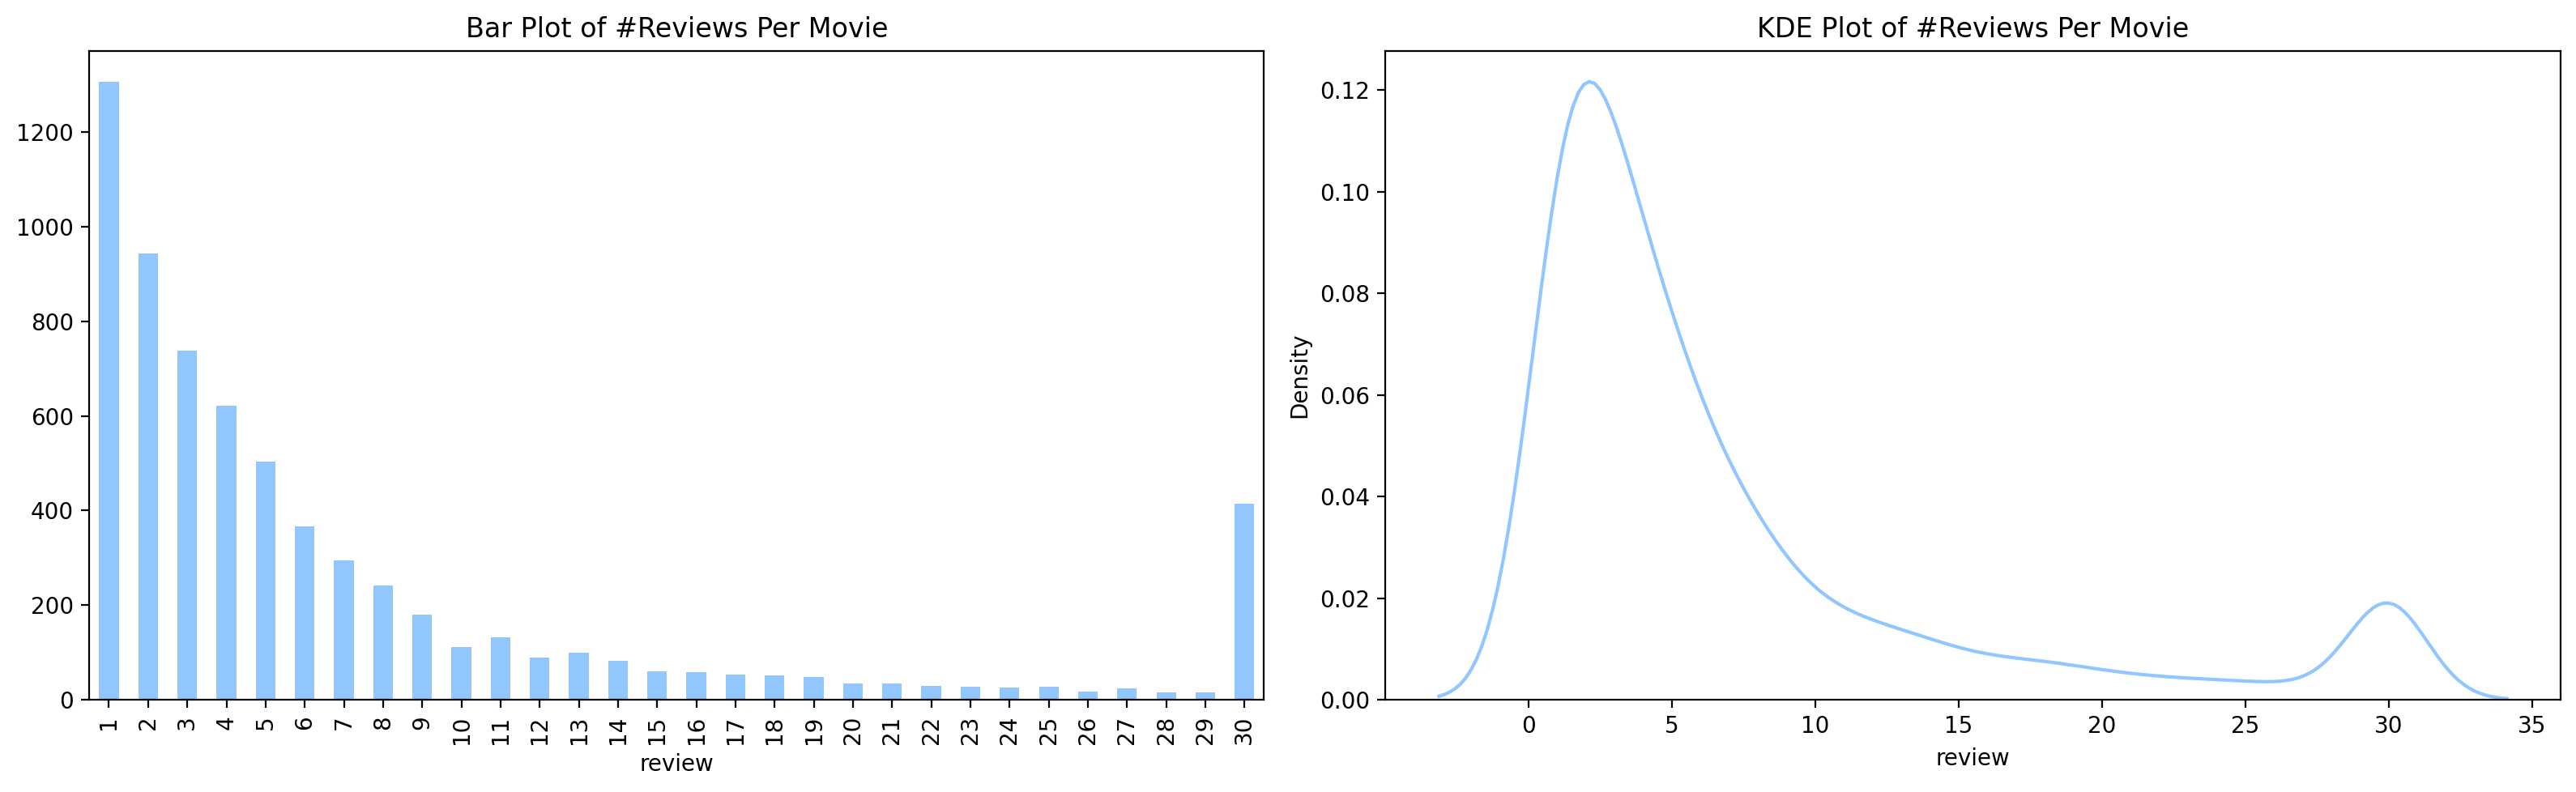

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [10]:
# Checking class balance:

df_reviews['pos'].value_counts(normalize=True) * 100

pos
0    50.104583
1    49.895417
Name: proportion, dtype: float64

Let's create two bar charts side by side, comparing the distribution of ratings in the training set and the test set.

This code will help me visually compare the distribution of ratings in the training and testing sets, ensuring that they have a similar distribution or highlighting possible differences.

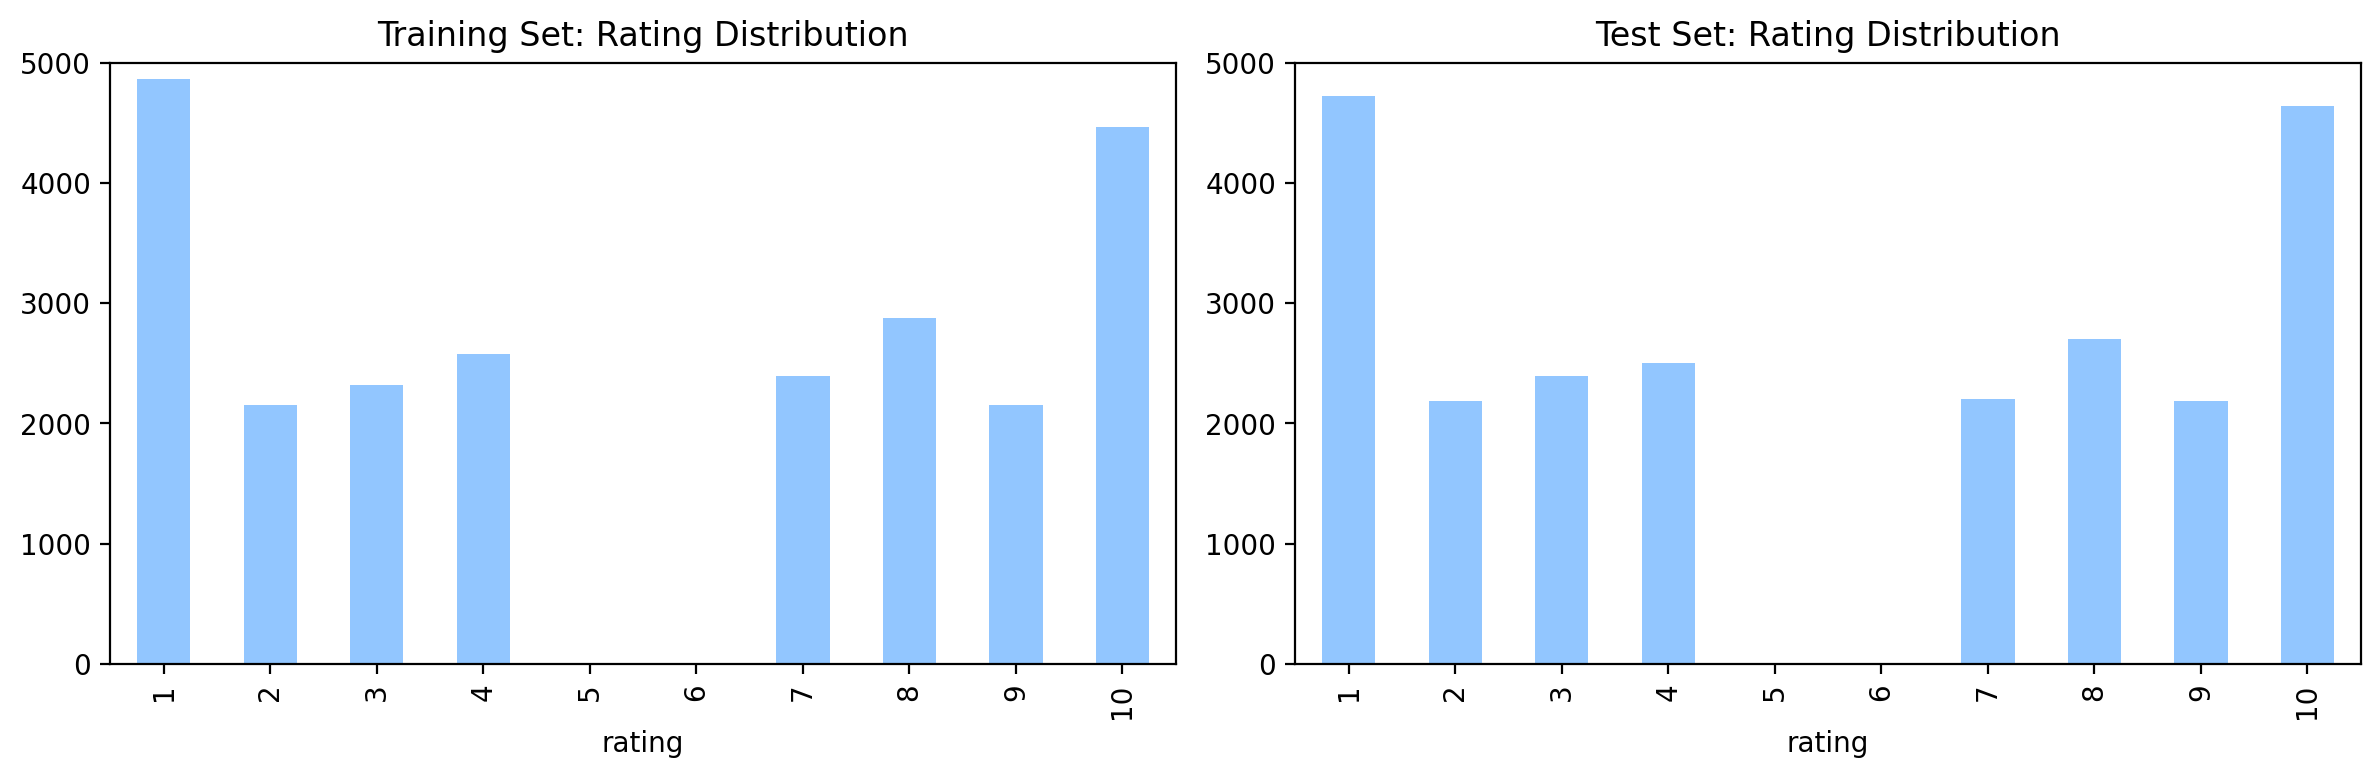

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Training Set: Rating Distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test Set: Rating Distribution')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

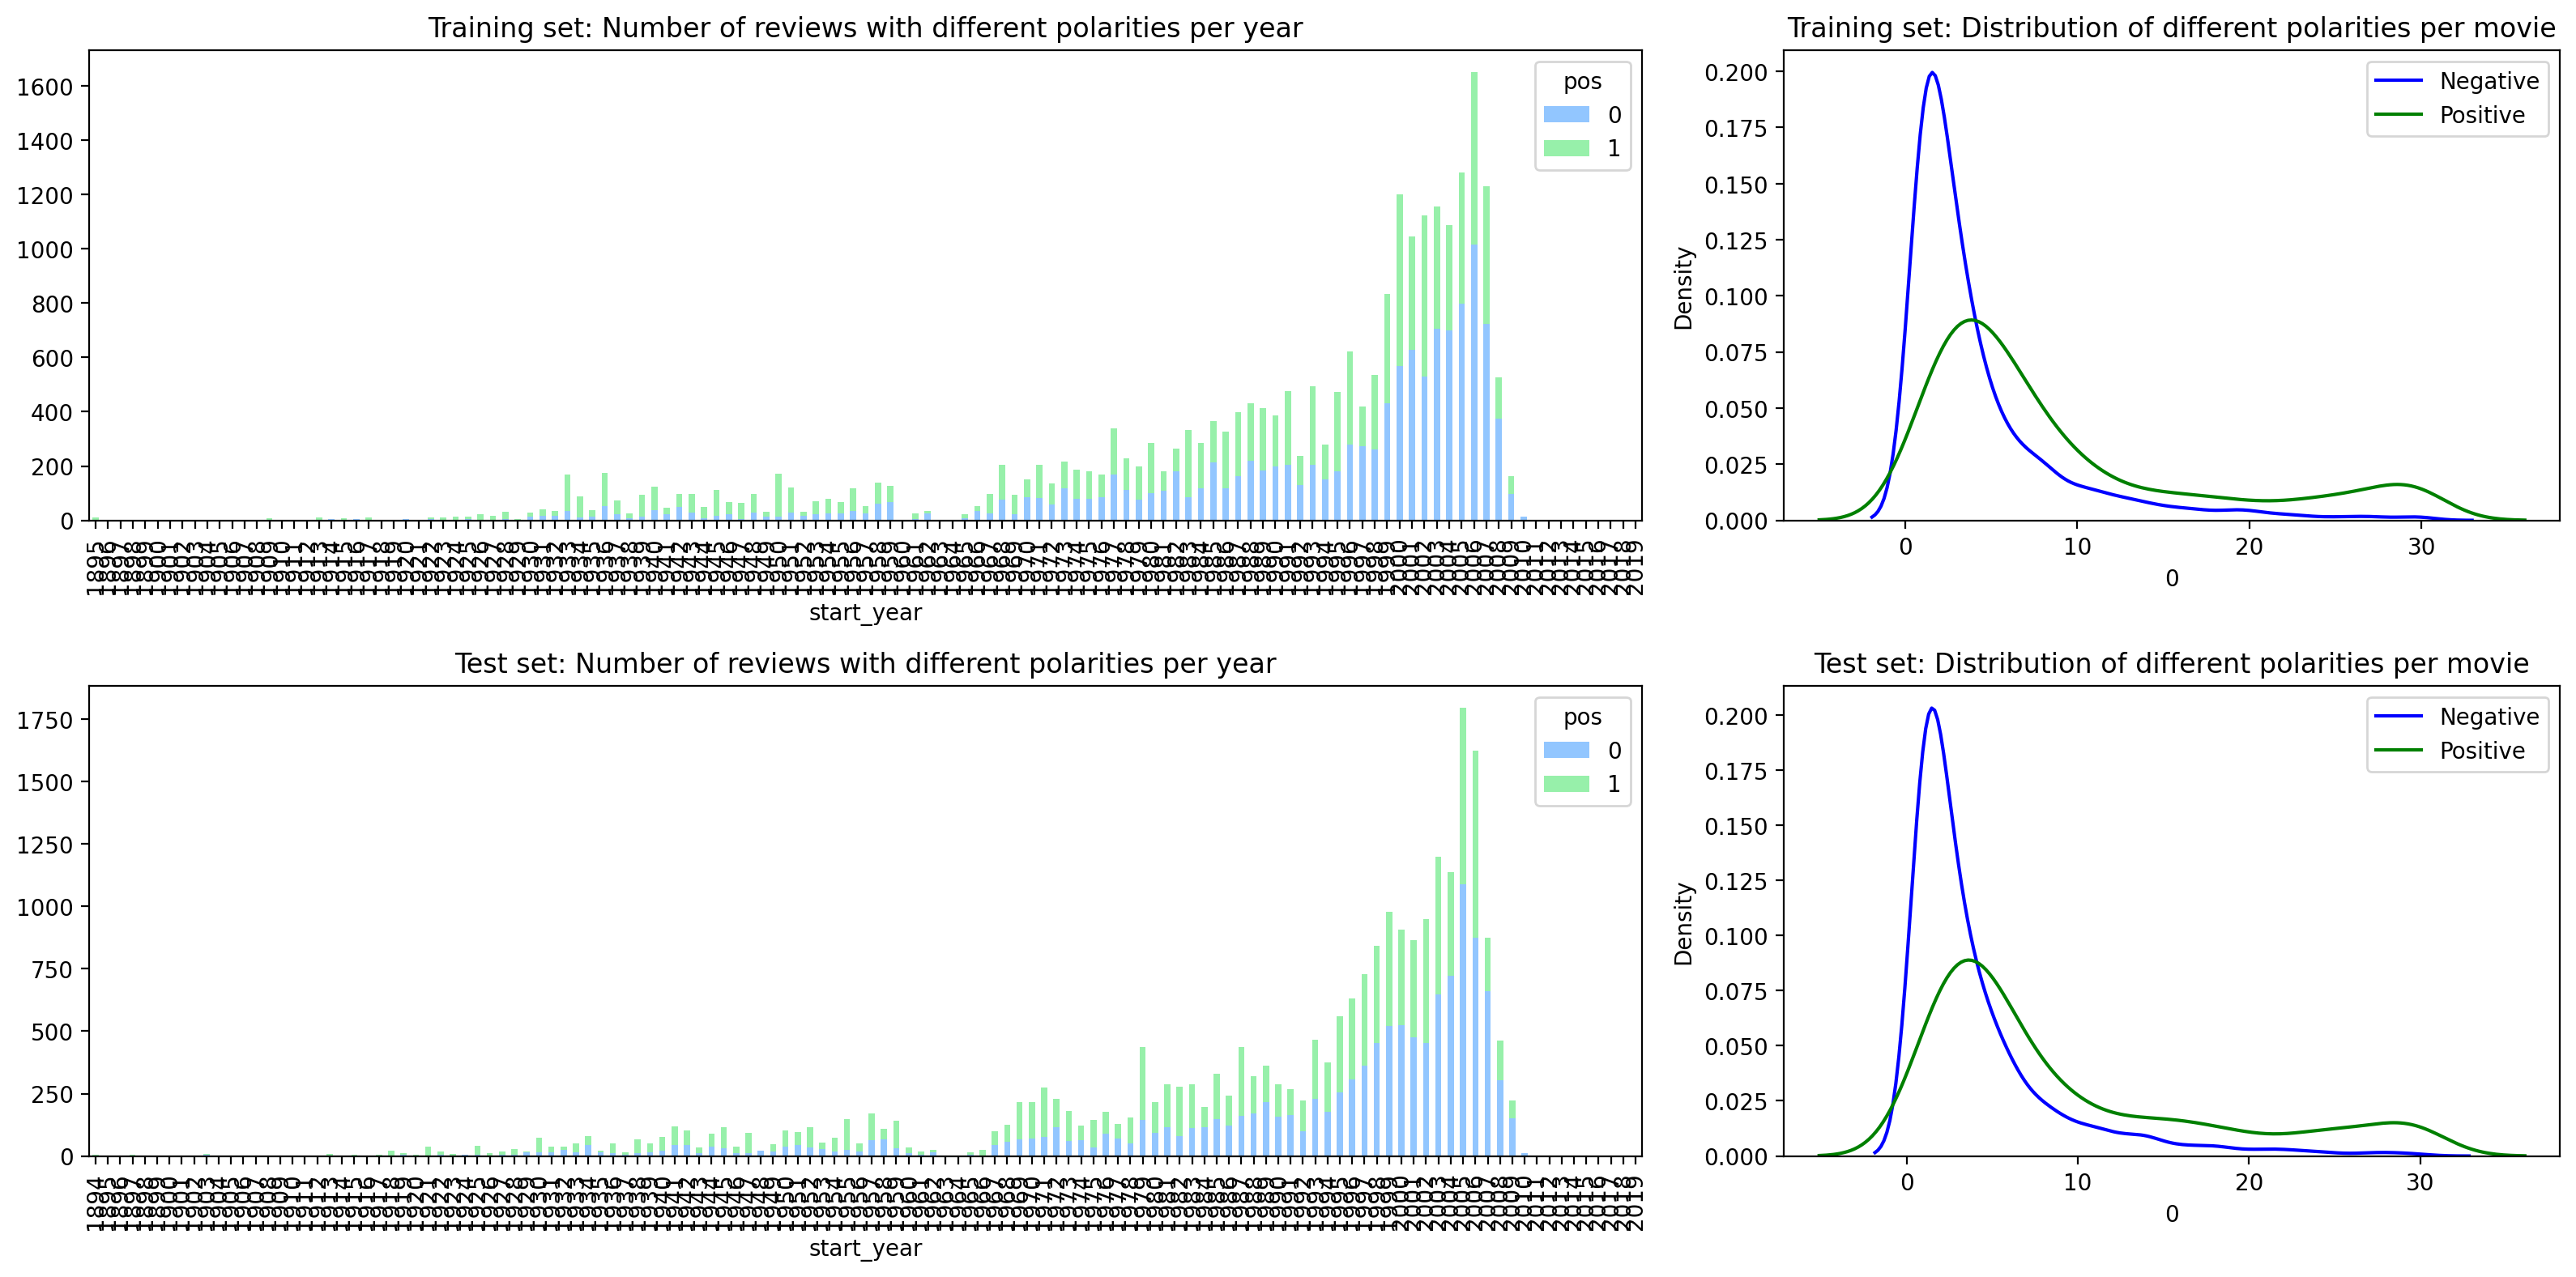

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

# First plot (top left): Number of reviews with different polarities per year in the training set
ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Training set: Number of reviews with different polarities per year')

# Second plot (top right): Distribution of different polarities per movie in the training set
ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='Negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='Positive', ax=ax)
ax.legend()
ax.set_title('Training set: Distribution of different polarities per movie')

# Third plot (bottom left): Number of reviews with different polarities per year in the test set
ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: Number of reviews with different polarities per year')

# Fourth plot (bottom right): Distribution of different polarities per movie in the test set
ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='Negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='Positive', ax=ax)
ax.legend()
ax.set_title('Test set: Distribution of different polarities per movie')

fig.tight_layout()

The plots allowed for a visual comparison of the balance and trends in the data across different datasets. The data appears to be consistent.

<h2 style = 'color: orange'> Model Evaluation Procedure:</h2>

Composing an evaluation routine that can be used for all models in this project.

In [13]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    # Create a figure with 3 subplots (for F1, ROC, and Precision-Recall curves)
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        # Make predictions and probability estimates
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1 Score
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba >= threshold) for threshold in f1_thresholds]
        
        # Save the maximum F1 Score
        max_f1_score = np.max(f1_scores)
        eval_stats[type]['F1 Score'] = max_f1_score
        
        # ROC Curve
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Precision-Recall Curve
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Set color based on dataset type
        color = 'blue' if type == 'train' else 'green'

        # F1 Score Plot
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Set markers for certain thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Threshold')
        ax.set_ylabel('F1 Score')
        ax.legend(loc='lower center')
        ax.set_title('F1 Score')

        # ROC Curve Plot
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Set markers for certain thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend(loc='lower center')        
        ax.set_title('ROC Curve')
        
        # Precision-Recall Curve Plot
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Set markers for certain thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds - threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend(loc='lower center')
        ax.set_title('Precision-Recall Curve')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    # Create a DataFrame to display evaluation statistics
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1 Score', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

<h2 style = 'color: orange'> Normalization:</h2>

In [14]:
import re

# Function to normalize the text
def normalize_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [15]:
# Apply the normalization function to the 'review' column and create a new 'review_norm' column:

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

In [16]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        im totally agree with garryjohal from singapor...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought id say this about a biopic but...
47329    spirit and chaos is an artistic biopic of miya...
47330    ill make this brief this was a joy to watch it...
Name: review_norm, Length: 47331, dtype: object

<h2 style = 'color: orange'> ML:</h2>

In [17]:
# Separating data based on 'ds_part' column:

df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


<h4 style = 'color: orange'>Model 0 - Dummy Classifier:</h4>

In [18]:
# Creation of the DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')  # or 'uniform', 'stratified', 'constant'

# Training the Dummy model
dummy_clf.fit(df_reviews_train[['review_norm']], train_target)

# Predictions on the test set
test_predictions = dummy_clf.predict(df_reviews_test[['review_norm']])

          train  test
Accuracy   0.50  0.50
F1 Score   0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


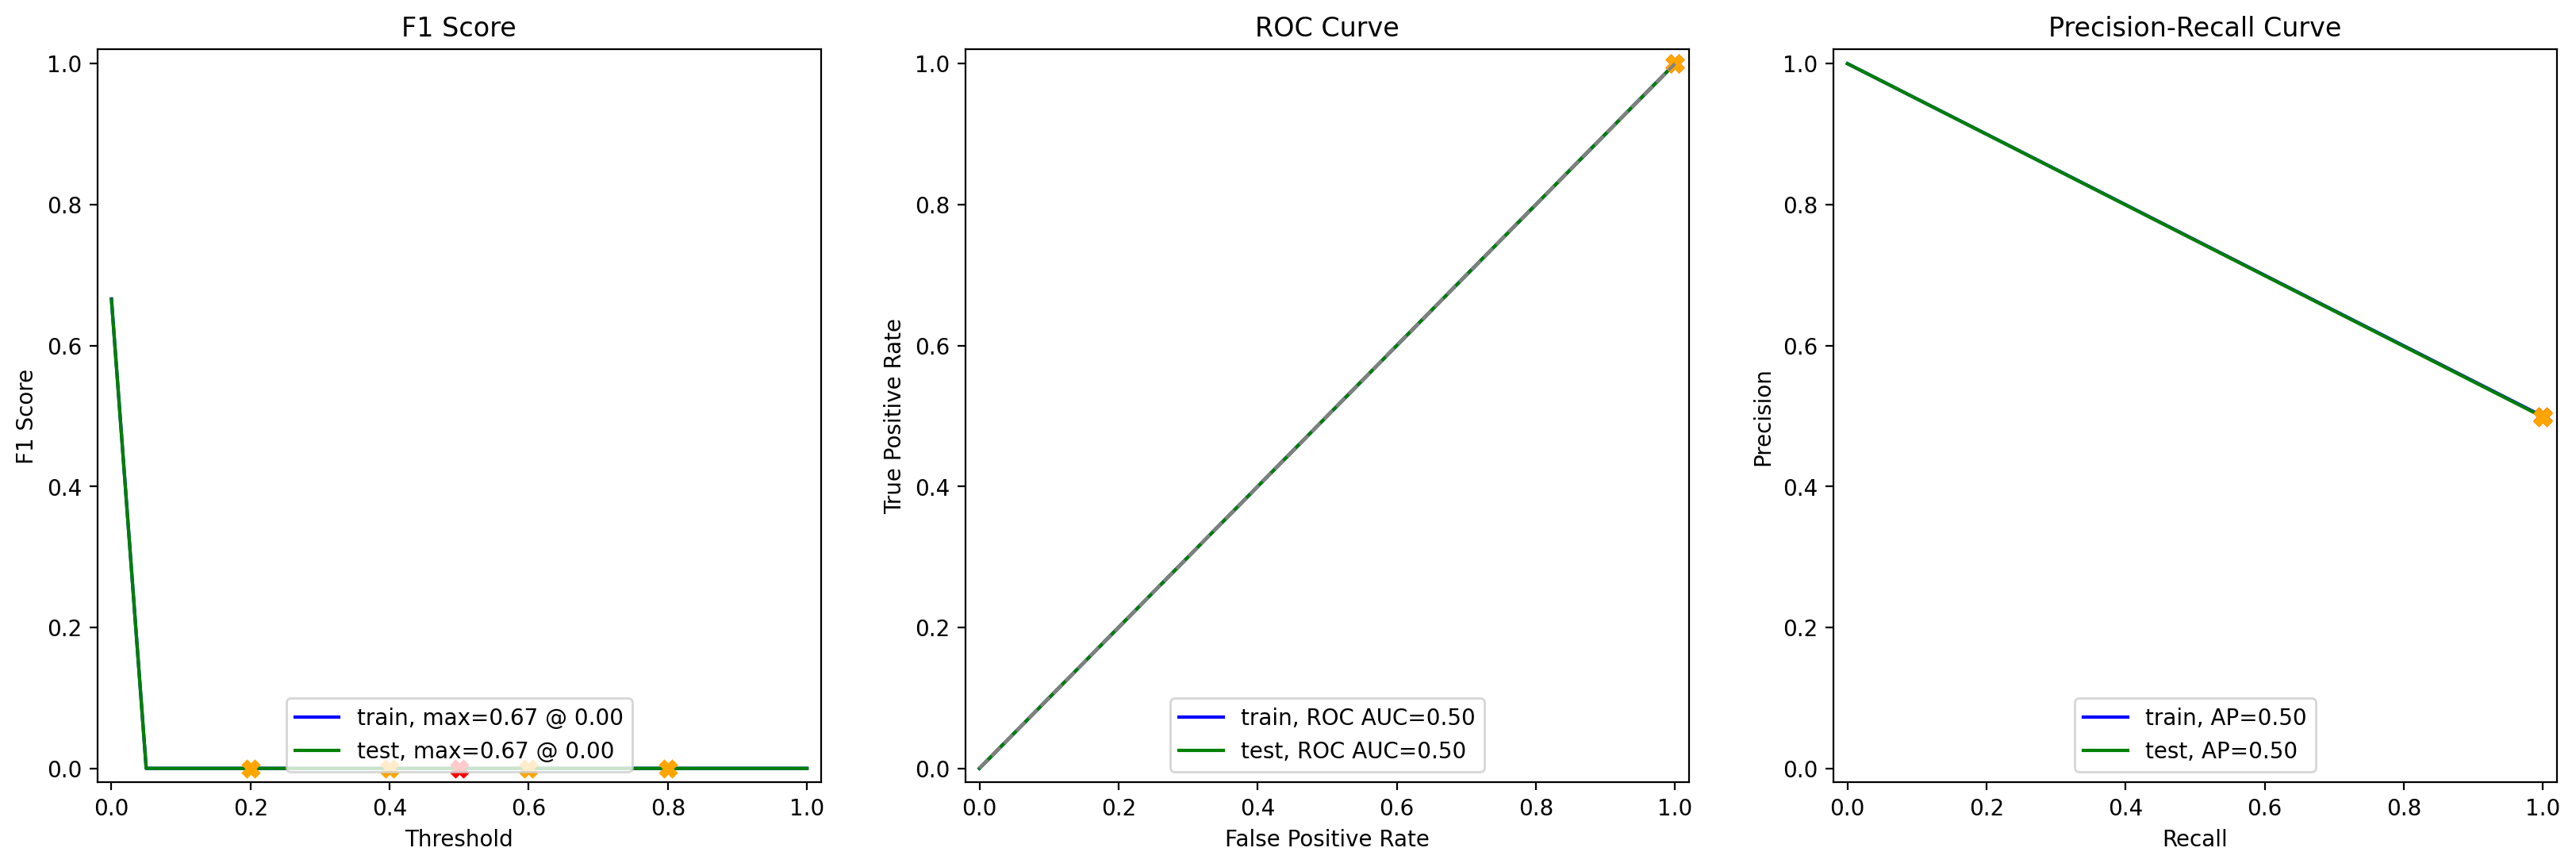

In [19]:
evaluate_model(dummy_clf, df_reviews_train[['review_norm']], train_target, df_reviews_test[['review_norm']], test_target)

Evaluation results indicate that DummyClassifier is behaving as expected for a baseline model

<h4 style = 'color: orange'> Model 1 - NLTK, TF-IDF and Linear Regression:</h4>

In [20]:
# Prepare the training data
train_corpus = df_reviews_train['review_norm']

# Define stop words
stop_words = list(nltk_stopwords.words('english'))

# Initialize and fit TF-IDF vectorizer
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit_transform(train_corpus)

# Define training features and target
train_features_1 = tf_idf
train_target_1 = df_reviews_train['pos']

# Prepare the test data
test_corpus = df_reviews_test['review_norm']
test_features_1 = count_tf_idf.transform(test_corpus)
test_target_1 = df_reviews_test['pos']

# Initialize and train the logistic regression model
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target_1)

# Make predictions on the test set
pred_test_1 = model_1.predict(test_features_1)

          train  test
Accuracy   0.94  0.88
F1 Score   0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


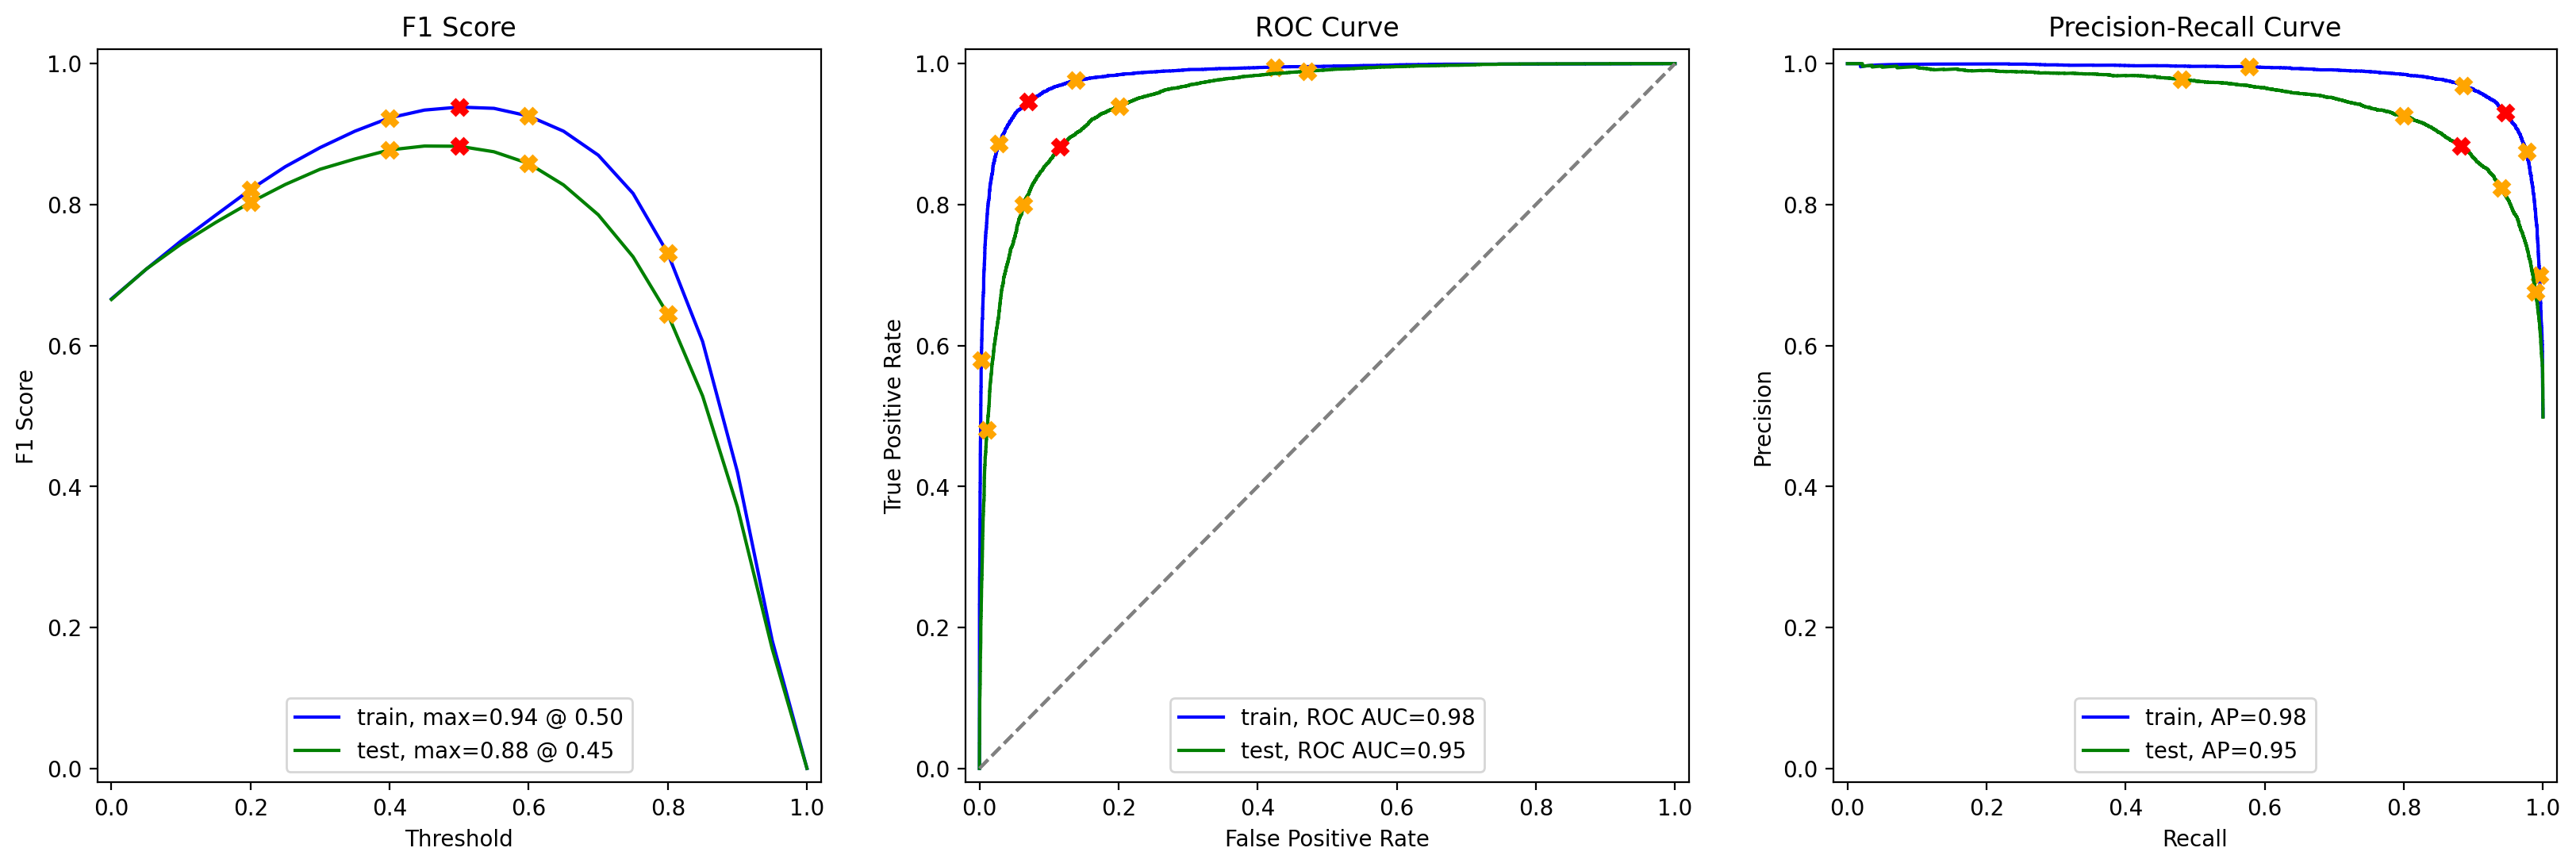

In [21]:
evaluate_model(model_1, train_features_1, train_target_1, test_features_1, test_target_1)

<h4 style = 'color: orange'> Model 2 - spaCy, TF-IDF and Linear Regression:</h4>

In [22]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text_spacy(text):
    doc = nlp(text)
    # Remove stop words and lemmatize
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

# Preprocess the training and test text using spaCy
train_corpus = df_reviews_train['review_norm'].apply(preprocess_text_spacy)
test_corpus = df_reviews_test['review_norm'].apply(preprocess_text_spacy)

# TF-IDF vectorization
stop_words = list(nlp.Defaults.stop_words)  # Get stop words from spaCy
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_2 = tfidf_vectorizer.fit_transform(train_corpus)
test_features_2 = tfidf_vectorizer.transform(test_corpus)

# Define target
train_target_2 = df_reviews_train['pos']
test_target_2 = df_reviews_test['pos']

# Train the logistic regression model
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target_2)

# Make predictions on the test set
pred_test_2 = model_2.predict(test_features_2)

c:\Users\Raphael\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


          train  test
Accuracy   0.93  0.87
F1 Score   0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


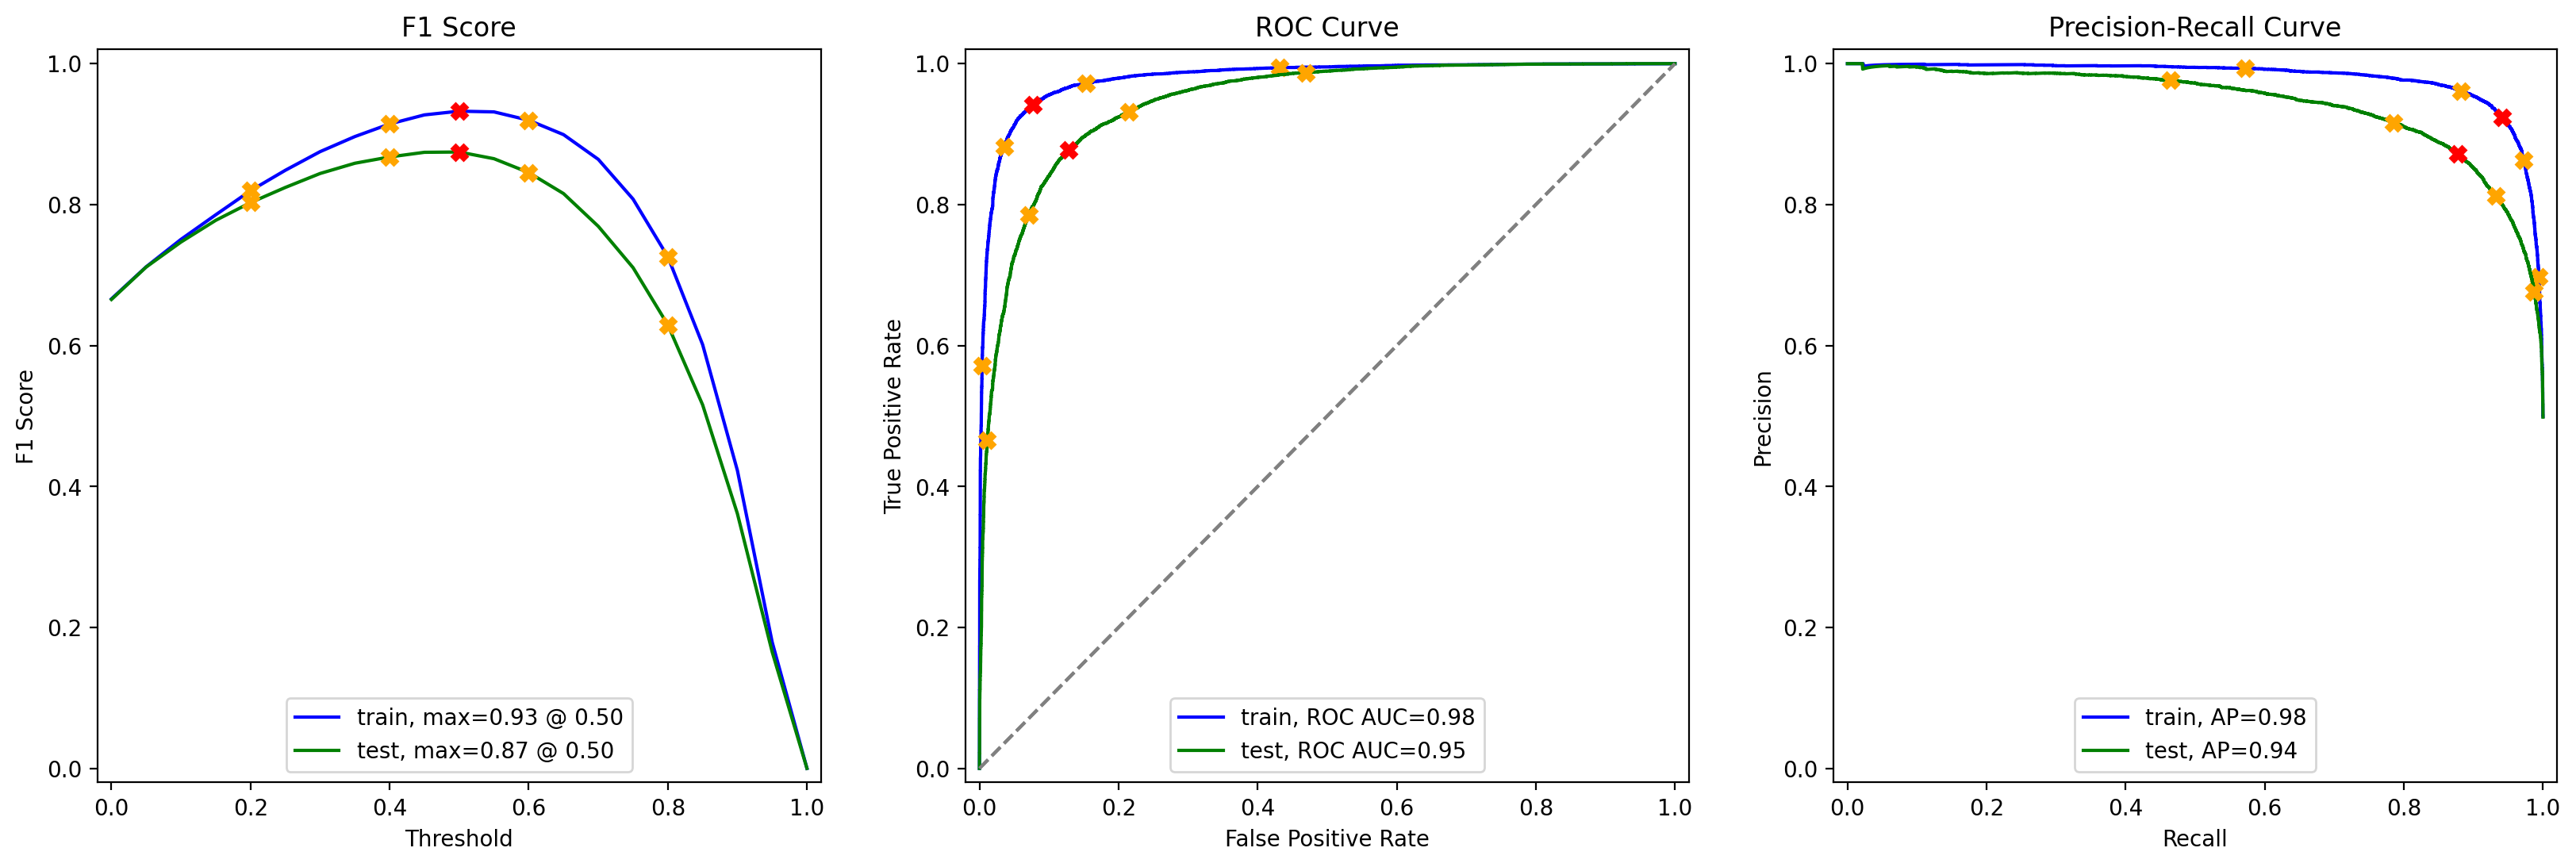

In [23]:
evaluate_model(model_2, train_features_2, train_target_2, test_features_2, test_target_2)

<h4 style = 'color: orange'> Model 3 - SpaCy, TF-IDF and LGBMClassifier:</h4>

In [24]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

def preprocess_text_spacy(text):
    doc = nlp(text)
    # Remove stop words and lemmatize
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

# Preprocess the training and test text using spaCy
train_corpus = df_reviews_train['review_norm'].apply(preprocess_text_spacy)
test_corpus = df_reviews_test['review_norm'].apply(preprocess_text_spacy)

# TF-IDF vectorization
stop_words = list(nlp.Defaults.stop_words)  # Get stop words from spaCy
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
train_features_3 = tfidf_vectorizer.fit_transform(train_corpus)
test_features_3 = tfidf_vectorizer.transform(test_corpus)

# Define target variables
train_target_3 = df_reviews_train['pos']
test_target_3 = df_reviews_test['pos']

# Initialize the LightGBM Classifier with random_state
model_3 = LGBMClassifier(random_state=12345)

# Train the LightGBM Classifier
model_3.fit(train_features_3, train_target_3)

# Make predictions on the test set
pred_test_3 = model_3.predict(test_features_3)

c:\Users\Raphael\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.977753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 417962
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9199
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


          train  test
Accuracy   0.91  0.85
F1 Score   0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


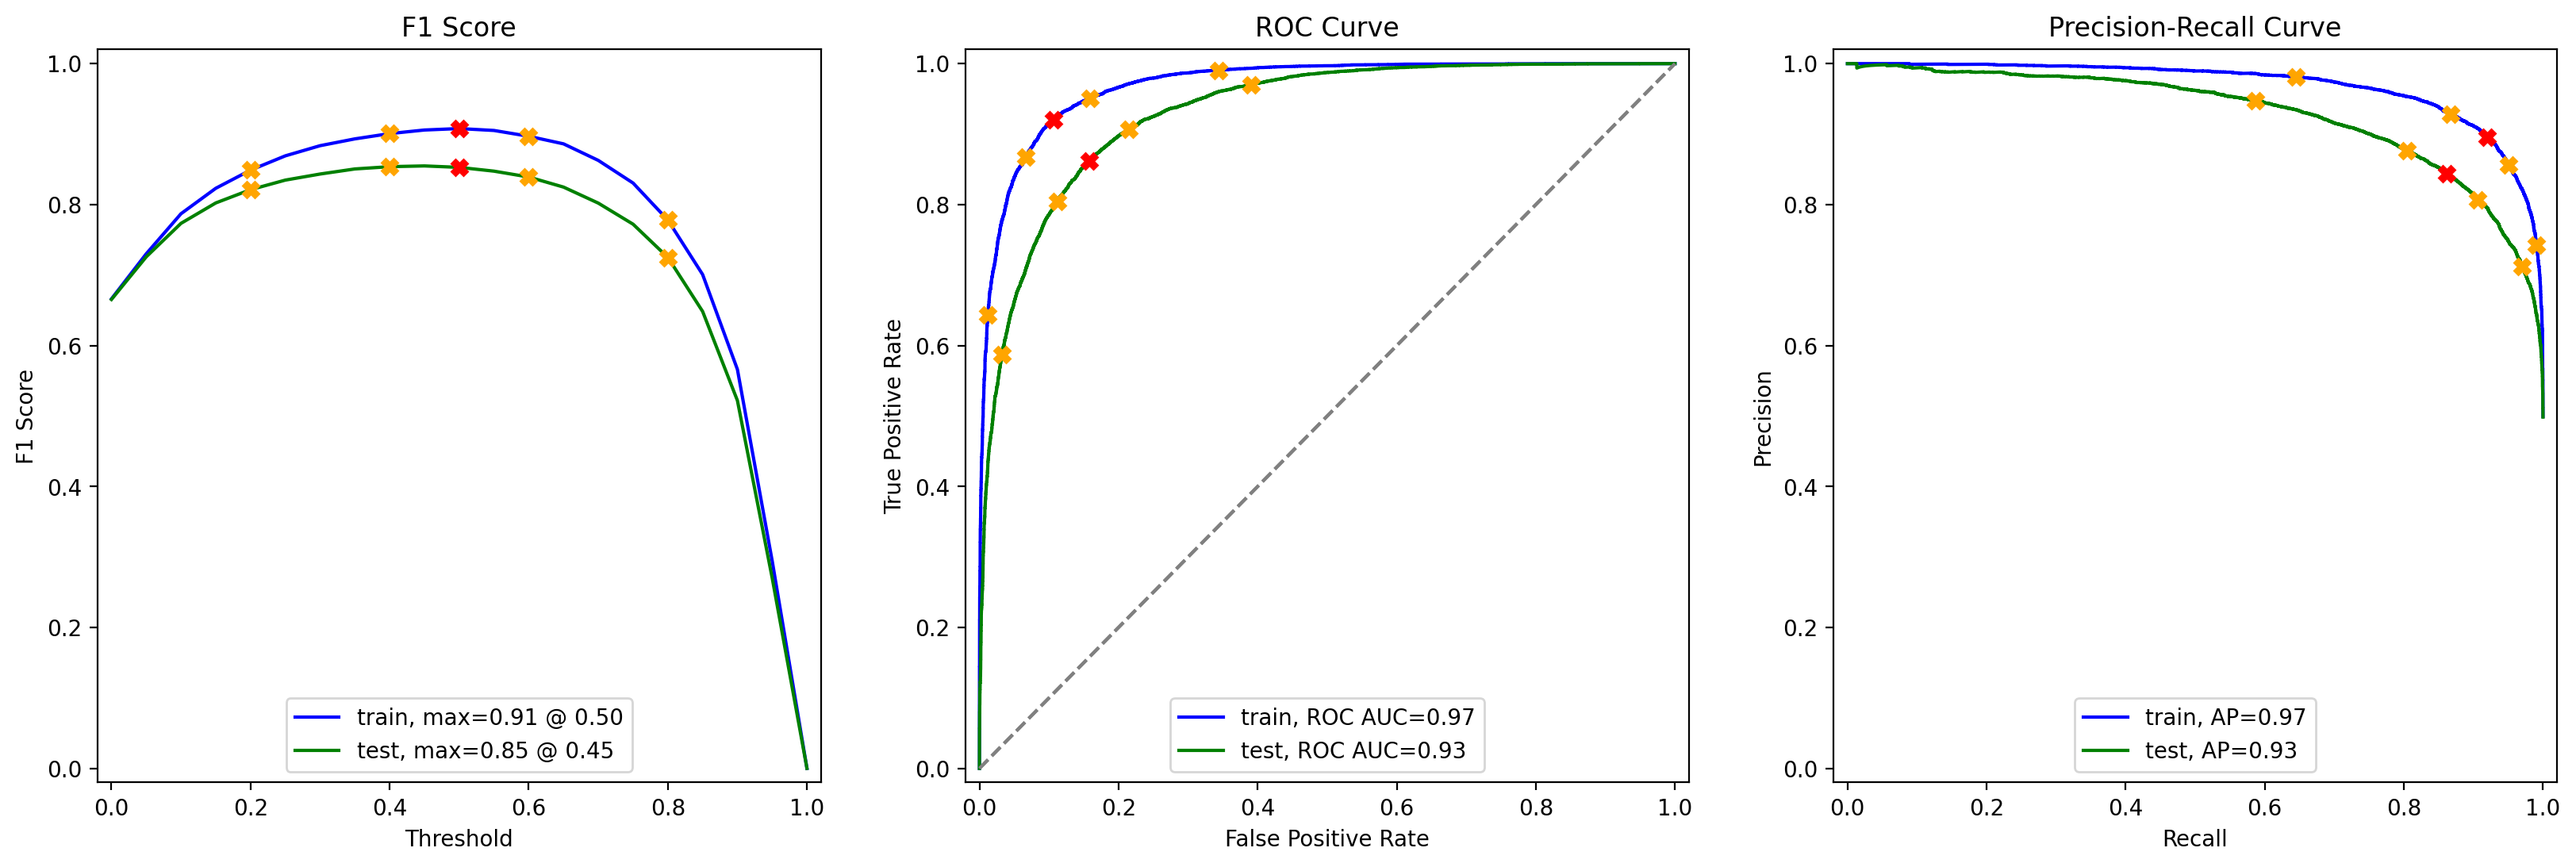

In [25]:
evaluate_model(model_3, train_features_3, train_target_3, test_features_3, test_target_3)

The three models used achieved F1 scores higher than the required 0.85. It is notable that the less sophisticated models produced superior results. I will reassess the models' performance using the new reviews.

<h2 style = 'color: orange'> New reviews:</h2>

In [26]:
new_reviews = pd.DataFrame([
    'Absolutely disliked it, not my kind of movie.',
    'Well, I got bored and fell asleep in the middle of the movie.',
    'I was truly fascinated by the movie',    
    'The actors seemed very old and disinterested, and yet they were paid to be in the film. What a shameless money grab.',
    'I didn’t expect the new version to be so good! The writers really cared about the original material',
    'The movie has its pros and cons, but I feel that overall it’s a decent film. I can see myself going to watch it again.',
    'What a pathetic attempt at comedy. Not a single joke lands, everyone acts annoyingly and loudly, even kids won’t like this!',
    'Releasing it on Netflix was a bold move and I really appreciate being able to watch episode after episode of this exciting and smart new drama.'
], columns=['review'])

# Normalization
new_reviews['review_norm'] = new_reviews['review'].apply(normalize_text)

new_reviews

,review,review_norm
0,"Absolutely disliked it, not my kind of movie.",absolutely disliked it not my kind of movie
1,"Well, I got bored and fell asleep in the middl...",well i got bored and fell asleep in the middle...
2,I was truly fascinated by the movie,i was truly fascinated by the movie
3,"The actors seemed very old and disinterested, ...",the actors seemed very old and disinterested a...
4,I didn’t expect the new version to be so good!...,i didnt expect the new version to be so good t...
5,"The movie has its pros and cons, but I feel th...",the movie has its pros and cons but i feel tha...
6,What a pathetic attempt at comedy. Not a singl...,what a pathetic attempt at comedy not a single...
7,Releasing it on Netflix was a bold move and I ...,releasing it on netflix was a bold move and i ...


<h4 style = 'color: orange'> Model 1 - NLTK, TF-IDF and Linear Regression:</h4>

In [27]:
# Extract the normalized texts
texts = new_reviews['review_norm']

# Calculate prediction probabilities (probabilities for the positive class)
new_reviews_pred_prob_1 = model_1.predict_proba(count_tf_idf.transform(texts))[:, 1]

# Display the probabilities along with the first 100 characters of each revieww
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{new_reviews_pred_prob_1[i]:.2f}:  {review}')

0.29:  absolutely disliked it not my kind of movie
0.20:  well i got bored and fell asleep in the middle of the movie
0.68:  i was truly fascinated by the movie
0.12:  the actors seemed very old and disinterested and yet they were paid to be in the film what a shamele
0.17:  i didnt expect the new version to be so good the writers really cared about the original material
0.65:  the movie has its pros and cons but i feel that overall its a decent film i can see myself going to 
0.09:  what a pathetic attempt at comedy not a single joke lands everyone acts annoyingly and loudly even k
0.86:  releasing it on netflix was a bold move and i really appreciate being able to watch episode after ep


<h4 style = 'color: orange'> Model 2 - spaCy, TF-IDF and Linear Regression:</h4>

In [28]:
# Extract the normalized texts
texts = new_reviews['review_norm']

# Calculate prediction probabilities (probabilities for the positive class)
new_reviews_pred_prob_2 = model_2.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

# Display the probabilities along with the first 100 characters of each revieww
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{new_reviews_pred_prob_2[i]:.2f}:  {review}')

0.23:  absolutely disliked it not my kind of movie
0.17:  well i got bored and fell asleep in the middle of the movie
0.66:  i was truly fascinated by the movie
0.30:  the actors seemed very old and disinterested and yet they were paid to be in the film what a shamele
0.41:  i didnt expect the new version to be so good the writers really cared about the original material
0.42:  the movie has its pros and cons but i feel that overall its a decent film i can see myself going to 
0.09:  what a pathetic attempt at comedy not a single joke lands everyone acts annoyingly and loudly even k
0.90:  releasing it on netflix was a bold move and i really appreciate being able to watch episode after ep


<h4 style = 'color: orange'> Model 3 - spaCy, TF-IDF and LGBMClassifier:</h4>

In [29]:
# Extract the normalized texts
texts = new_reviews['review_norm']

# Calculate prediction probabilities (probabilities for the positive class)
new_reviews_pred_prob_3 = model_3.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

# Display the probabilities along with the first 100 characters of each revieww
for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{new_reviews_pred_prob_3[i]:.2f}:  {review}')

0.56:  absolutely disliked it not my kind of movie
0.32:  well i got bored and fell asleep in the middle of the movie
0.65:  i was truly fascinated by the movie
0.47:  the actors seemed very old and disinterested and yet they were paid to be in the film what a shamele
0.73:  i didnt expect the new version to be so good the writers really cared about the original material
0.59:  the movie has its pros and cons but i feel that overall its a decent film i can see myself going to 
0.14:  what a pathetic attempt at comedy not a single joke lands everyone acts annoyingly and loudly even k
0.78:  releasing it on netflix was a bold move and i really appreciate being able to watch episode after ep


<h2 style = 'color: orange'> Model performance with new reviews:</h2>

In [30]:
# Example DataFrame with predicted probabilities and ground truth
df_results = pd.DataFrame({
    'new_reviews_pred_prob_1': [0.29, 0.20, 0.68, 0.12, 0.17, 0.65, 0.09, 0.86],
    'new_reviews_pred_prob_2': [0.23, 0.17, 0.66, 0.30, 0.41, 0.42, 0.09, 0.90],
    'new_reviews_pred_prob_3': [0.56, 0.32, 0.65, 0.47, 0.73, 0.59, 0.14, 0.78],
    'ground_truth': [0, 0, 1, 0, 1, 1, 0, 1]
})

# Define thresholds to evaluate
thresholds = np.linspace(0, 1, 101)

def evaluate_thresholds(pred_probs, ground_truth):
    best_accuracy = 0
    best_threshold = None
    
    for threshold in thresholds:
        predictions = (pred_probs >= threshold).astype(int)
        accuracy = accuracy_score(ground_truth, predictions)
        
        # Update best accuracy and corresponding threshold
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold
        # If accuracy is the same, choose the threshold closer to 0.5
        elif accuracy == best_accuracy:
            if abs(threshold - 0.5) < abs(best_threshold - 0.5):
                best_threshold = threshold

    return best_accuracy, best_threshold

# Evaluate each model
accuracy_1, threshold_1 = evaluate_thresholds(df_results['new_reviews_pred_prob_1'], df_results['ground_truth'])
accuracy_2, threshold_2 = evaluate_thresholds(df_results['new_reviews_pred_prob_2'], df_results['ground_truth'])
accuracy_3, threshold_3 = evaluate_thresholds(df_results['new_reviews_pred_prob_3'], df_results['ground_truth'])

# Compare models
print(f"Max accuracy for Model 1: {accuracy_1:.2f} at threshold {threshold_1:.2f}")
print(f"Max accuracy for Model 2: {accuracy_2:.2f} at threshold {threshold_2:.2f}")
print(f"Max accuracy for Model 3: {accuracy_3:.2f} at threshold {threshold_3:.2f}")

# Store accuracies and thresholds
accuracies = [accuracy_1, accuracy_2, accuracy_3]
thresholds = [threshold_1, threshold_2, threshold_3]

# Find the maximum accuracy
max_accuracy = max(accuracies)

# Get indices of models with maximum accuracy
best_model_indices = [i for i, acc in enumerate(accuracies) if acc == max_accuracy]

# If there's a tie, choose the model with threshold closest to 0.5
if len(best_model_indices) > 1:
    best_model_index = min(best_model_indices, key=lambda i: abs(thresholds[i] - 0.5))
else:
    best_model_index = best_model_indices[0]

best_model = best_model_index + 1  # Adjust index to match model numbering
print(f"The best model is Model {best_model} with the highest accuracy of {max_accuracy:.2f} and a threshold closest to 0.5 at {thresholds[best_model_index]:.2f}")

Max accuracy for Model 1: 0.88 at threshold 0.50
Max accuracy for Model 2: 1.00 at threshold 0.40
Max accuracy for Model 3: 1.00 at threshold 0.57
The best model is Model 3 with the highest accuracy of 1.00 and a threshold closest to 0.5 at 0.57


<h2 style = 'color: orange'> Conclusions:</h2>


Even though these models are not the most sophisticated ones currently available for NLP tasks, it was possible to achieve good results. The models proved to be sufficient for the intended purpose.

Unlike the results observed in the training and testing sets, Model 3 (the most sophisticated) performed better than the others with the new reviews. In fact, the entire order of performance reversed to align with the expected hierarchy.
